[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/chatbot-summarization.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239436-lesson-5-chatbot-w-summarizing-messages-and-memory)

# Thread memory

Let's do something to avoid passing state every time and allow agent to persistently accumulate info.
The answer is thread memory!

In [112]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [113]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [114]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

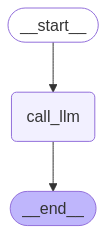

In [115]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def call_llm(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("call_llm", call_llm)
builder.add_edge(START, "call_llm")
builder.add_edge("call_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [116]:
from langchain_core.messages import HumanMessage

state = graph.invoke({"messages": [HumanMessage(content="Hi! I'm Lance")]})

for m in state['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi! I'm Lance
================================== Ai Message ==================================

Nice to meet you, Lance! How can I assist you today?


In [117]:
from langchain_core.messages import HumanMessage

state = graph.invoke({"messages": [HumanMessage(content="What is my name?")]})

for m in state['messages']:
    m.pretty_print()

================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

I'm sorry, I do not have access to personal information such as your name.


## Adding memory

We will use `MemorySaver` - easy-to-use in-memory key-value store for Graph state. All we need to do is compile the graph with a checkpointer, and our graph has memory!

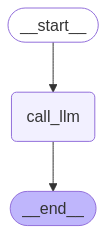

In [118]:
from langgraph.checkpoint.memory import MemorySaver
# Init in-memory storage
memory = MemorySaver()
# Compile graph passing memory as a checkpointer
graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

## Checkpoints

The `checkpointer` saves the state at each step as a checkpoint.

These saved checkpoints can be grouped into a `thread` of conversation. Think about Slack as an analog: different channels carry different conversations. Threads are like Slack channels, capturing grouped collections of state (e.g., conversation).

Below, we use `configurable` to set a thread ID.

![state.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbadf3b379c2ee621adfd1_chatbot-summarization1.png)

In [119]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

In [120]:
graph.get_state(config)

StateSnapshot(values={}, next=(), config={'configurable': {'thread_id': '1'}}, metadata=None, created_at=None, parent_config=None, tasks=())

`StateSnapshot` object with the following key properties:
* config: Config associated with this checkpoint.
* metadata: Metadata associated with this checkpoint.
* values: Values of the state channels at this point in time.
* next A tuple of the node names to execute next in the graph.
* tasks: A tuple of PregelTask objects that contain information about next tasks to be executed. If the step was previously attempted, it will include error information. If a graph was interrupted dynamically from within a node, tasks will contain additional data associated with interrupts.

https://langchain-ai.github.io/langgraph/concepts/persistence/

In [121]:
# Start conversation
input_message = HumanMessage(content="Hi! I'm Lance")
state = graph.invoke({"messages": [input_message]}, config)

for m in state['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi! I'm Lance
================================== Ai Message ==================================

Nice to meet you, Lance! How can I assist you today?


If we look at checkpoint state, we will see exactly this list of messages:

In [122]:
for m in graph.get_state(config).values.get("messages"): # Q: When checkpoints are created?
    m.pretty_print()

================================ Human Message =================================

Hi! I'm Lance
================================== Ai Message ==================================

Nice to meet you, Lance! How can I assist you today?


In [123]:
state = graph.invoke({"messages": [HumanMessage(content="What's my name?")]}, config)

for m in state['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi! I'm Lance
================================== Ai Message ==================================

Nice to meet you, Lance! How can I assist you today?
================================ Human Message =================================

What's my name?
================================== Ai Message ==================================

Your name is Lance.


In [124]:
config

{'configurable': {'thread_id': '1'}}

In [125]:
graph.get_state(config).values.get("messages")

[HumanMessage(content="Hi! I'm Lance", additional_kwargs={}, response_metadata={}, id='4e5ce0ec-ddb8-4cfe-83bd-4bf155ccbfd9'),
 AIMessage(content='Nice to meet you, Lance! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 12, 'total_tokens': 27, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BELe5ETYv5PINjhs9pwtQrqaDrWde', 'finish_reason': 'stop', 'logprobs': None}, id='run-f6410607-a185-42d4-ae73-230f96253067-0', usage_metadata={'input_tokens': 12, 'output_tokens': 15, 'total_tokens': 27, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
 HumanMessage(content="What's my name?", additional_kwargs={},

In [126]:
# Get all saved checkpoints
for checkpoint in list(graph.get_state_history(config)):
    print("_________________________________ CHECKPOINT ___________________________________")
    print(checkpoint.next)
    messages = checkpoint.values.get('messages')
    for m in messages:
        m.pretty_print()
    print("________________________________________________________________________________\n\n")

# Q: When checkpoints are saved?

_________________________________ CHECKPOINT ___________________________________
()
================================ Human Message =================================

Hi! I'm Lance
================================== Ai Message ==================================

Nice to meet you, Lance! How can I assist you today?
================================ Human Message =================================

What's my name?
================================== Ai Message ==================================

Your name is Lance.
________________________________________________________________________________


_________________________________ CHECKPOINT ___________________________________
('call_llm',)
================================ Human Message =================================

Hi! I'm Lance
================================== Ai Message ==================================

Nice to meet you, Lance! How can I assist you today?
================================ Human Message =============================

In [127]:
# Q: Can I access thread 1 info from thread 2?